# Getting Started with PyFixest

In a first step, we load the module and some example data:

In [1]:
%load_ext autoreload
%autoreload 2

from pyfixest.estimation import feols, fepois
from pyfixest.summarize import summary
from pyfixest.visualize import coefplot, iplot
from pyfixest.utils import get_data

In [2]:
data = get_data()
data.head()

,Y,Y2,X1,X2,f1,f2,f3,group_id,Z1,Z2
0,NaN,-9.166216,2.0,0.457858,9.0,15.0,0.0,1.0,1.387208,2.018192
1,2.486016,-3.571090,NaN,-4.998406,8.0,6.0,9.0,11.0,NaN,-2.967624
2,1.449755,-3.721375,1.0,1.558480,NaN,11.0,0.0,18.0,2.531429,3.008302
3,4.443920,13.960173,0.0,1.560402,15.0,1.0,4.0,15.0,0.163519,2.086421
4,1.193511,-6.568647,2.0,-3.472232,20.0,19.0,9.0,5.0,2.769067,-3.645078


## OLS Estimation

We can estimate a fixed effects regression via the `feols()` function. `feols()` has three arguments: a two-sided model formula, the data, and optionally, the type of inference.

In [3]:
fit = feols(fml="Y~X1 | f1", data=data, vcov="HC1")
type(fit)

pyfixest.feols.Feols

The first part of the formula contains the dependent variable and "regular" covariates, while the second part contains fixed effects.

`feols()` returns an instance of the `Fixest` class.

To inspect the results, we can use a summary function or method:

In [4]:
fit.summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: f1
Inference:  HC1
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| X1            |      0.337 |        0.056 |     6.039 |      0.000 |   0.228 |    0.447 |
---
RMSE: 1.422  Adj. R2: 0.035  Adj. R2 Within: 0.035


Alternatively, the `.summarize` module contains a `summary` function, which can be applied on instances of regression model objects 
or lists of regression model objects. 

In [5]:
summary(fit)

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: f1
Inference:  HC1
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| X1            |      0.337 |        0.056 |     6.039 |      0.000 |   0.228 |    0.447 |
---
RMSE: 1.422  Adj. R2: 0.035  Adj. R2 Within: 0.035


You can access individual elements of the summary via dedicated methods: `.tidy()` returns a "tidy" `pd.DataFrame`, 
`.coef()` returns estimated parameters, and `se()` estimated standard errors. Other methods include `pvalue()`, `confint()`
and `tstat()`.

In [6]:
fit.coef()

Coefficient
X1    0.337318
Name: Estimate, dtype: float64

In [7]:
fit.se()

Coefficient
X1    0.055861
Name: Std. Error, dtype: float64

## Standard Errors and Inference

Supported covariance types are "iid", "HC1-3", CRV1 and CRV3 (one-way clustering). Inference can be adjusted "on-the-fly" via the
`.vcov()` method:

In [8]:
fit.vcov({"CRV1": "group_id"}).summary()
fit.vcov({"CRV3": "group_id"}).summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: f1
Inference:  CRV1
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| X1            |      0.337 |        0.056 |     5.974 |      0.000 |   0.219 |    0.456 |
---
RMSE: 1.422  Adj. R2: 0.035  Adj. R2 Within: 0.035
###

Estimation:  OLS
Dep. var.: Y, Fixed effects: f1
Inference:  CRV3
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| X1            |      0.337 |        0.060 |     5.587 |      0.000 |   0.210 |    0.464 |
---
RMSE: 1.422  Adj. R2: 0.035  Adj. R2 Within: 0.035


It is also possible to run a wild (cluster) bootstrap after estimation (via the [wildboottest module](https://github.com/s3alfisc/wildboottest), only for Python
versions smaller than `3.11`):

In [9]:
fit2 = feols(fml="Y~ X1", data=data, vcov={"CRV1": "group_id"})
fit2.wildboottest(param="X1", B=999)

param                X1
statistic         5.542
pvalue              0.0
bootstrap_type       11
impose_null        True
dtype: object

Note that the wild bootstrap currently does not support fixed effects in the regression model. Supporting fixed effects is work in progress.

## IV Estimation 

It is also possible to estimate instrumental variable models with *one* endogenous variable and (potentially multiple) instruments:

In [10]:
iv_fit = feols(fml="Y2~ 1 | f1 + f2 | X1 ~ Z1 + Z2", data=data)
iv_fit.summary()

###

Estimation:  IV
Dep. var.: Y2, Fixed effects: f1+f2
Inference:  CRV1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| X1            |      0.355 |        0.313 |     1.137 |      0.265 |  -0.284 |    0.995 |
---


If the model does not contain any fixed effects, just drop the second part of the formula above:

In [11]:
feols(fml="Y~ 1 | X1 ~ Z1 + Z2", data=data).summary()

###

Estimation:  IV
Dep. var.: Y
Inference:  iid
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| Intercept     |      2.355 |        0.122 |    19.226 |      0.000 |   2.114 |    2.595 |
| X1            |      0.215 |        0.105 |     2.057 |      0.040 |   0.010 |    0.421 |
---


IV estimation with multiple endogenous variables and multiple estimation syntax is currently not supported. The syntax is "depvar ~ exog.vars | fixef effects | endog.vars ~ instruments".

## Poisson Regression 

With version `0.8.4`, it is possible to estimate Poisson Regressions (not yet on PyPi): 

In [12]:
from pyfixest.utils import get_data

pois_data = get_data(model = "Fepois")
pois_fit = fepois(fml="Y~X1 | f1+f2", data=pois_data, vcov={"CRV1": "group_id"})
pois_fit.summary()

###

Estimation:  Poisson
Dep. var.: Y, Fixed effects: f1+f2
Inference:  CRV1
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| X1            |      0.003 |        0.054 |     0.057 |      0.954 |  -0.103 |    0.109 |
---
Deviance: 1068.039


## Multiple Estimation 

`PyFixest` supports a range of multiple estimation functionality: `sw`, `sw0`, `csw`, `csw0`, and multiple dependent variables. If multiple regression syntax is used, 
`feols()` and `fepois` returns an instance of a `FixestMulti` object, which essentially consists of a dicionary of `Fepois` or `Feols` instances.

In [13]:
multi_fit = feols(fml="Y~X1 | csw0(f1, f2)", data=data, vcov="HC1")
multi_fit

In [14]:
multi_fit.summary()

###

Estimation:  OLS
Dep. var.: Y
Inference:  HC1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| Intercept     |      2.189 |        0.092 |    23.844 |      0.000 |   2.009 |    2.369 |
| X1            |      0.374 |        0.068 |     5.539 |      0.000 |   0.242 |    0.507 |
---
RMSE: 1.765  Adj. R2: 0.028  Adj. R2 Within: 0.028
###

Estimation:  OLS
Dep. var.: Y, Fixed effects: f1
Inference:  HC1
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| X1            |      0.337 |        0.056 |     6.039 |      0.000 |   0.228 |    0.447 |
---
RMSE: 1.422  Adj. R2: 0.035  Adj. R2 Within: 0.035
###

Estimation:  OLS
Dep. var.: Y, Fixed effects: f1+f2
Inference:  HC1
Observations

Alternatively, you can look at the estimation results via the `etable()` method:

In [15]:
multi_fit.etable()

fml              Y~X1        Y~X1|f1 Y~X1|f1+f2
Coefficient Intercept     X1      X1         X1
Estimate        2.189  0.374   0.337      0.379
Std. Error      0.092  0.068   0.056      0.046
t value        23.844  5.539   6.039      8.230
Pr(>|t|)        0.000  0.000   0.000      0.000
2.5 %           2.009  0.242   0.228      0.289
97.5 %          2.369  0.507   0.447      0.470

If you are only insterested in some parameters, e.g. "X1", you can use the following syntax:

In [16]:
multi_fit.etable().xs("X1", level=1, axis=1)

fml,Y~X1,Y~X1|f1,Y~X1|f1+f2
Estimate,0.374,0.337,0.379
Std. Error,0.068,0.056,0.046
t value,5.539,6.039,8.230
Pr(>|t|),0.000,0.000,0.000
2.5 %,0.242,0.228,0.289
97.5 %,0.507,0.447,0.470


You can access an individual model by its name - i.e. a formula - via the `all_fitted_models` attribure.

In [17]:
multi_fit.all_fitted_models["Y~X1"].tidy()

,Estimate,Std. Error,t value,Pr(>|t|),2.5 %,97.5 %
Coefficient,,,,,,
Intercept,2.189301,0.091816,23.844375,0.000000e+00,2.009126,2.369477
X1,0.374381,0.067585,5.539372,3.884382e-08,0.241755,0.507007


or equivalently via the `fetch_model` method:

In [18]:
multi_fit.fetch_model(0).tidy()

Model:  Y~X1


,Estimate,Std. Error,t value,Pr(>|t|),2.5 %,97.5 %
Coefficient,,,,,,
Intercept,2.189301,0.091816,23.844375,0.000000e+00,2.009126,2.369477
X1,0.374381,0.067585,5.539372,3.884382e-08,0.241755,0.507007


Here, `0` simply fetches the first model stored in the `all_fitted_models` dictionary, `1` the second etc.

Objects of type `Fixest` come with a range of additional methods: `tidy()`, `coef()`, `vcov()` etc, which 
essentially loop over the equivalent methods of all fitted models. E.g. `Fixest.vcov()` updates inference for all 
models stored in `Fixest`.

In [19]:
multi_fit.vcov("iid").summary()

###

Estimation:  OLS
Dep. var.: Y
Inference:  iid
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| Intercept     |      2.189 |        0.090 |    24.318 |      0.000 |   2.013 |    2.366 |
| X1            |      0.374 |        0.068 |     5.519 |      0.000 |   0.241 |    0.507 |
---
RMSE: 1.765  Adj. R2: 0.028  Adj. R2 Within: 0.028
###

Estimation:  OLS
Dep. var.: Y, Fixed effects: f1
Inference:  iid
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5 % |   97.5 % |
|:--------------|-----------:|-------------:|----------:|-----------:|--------:|---------:|
| X1            |      0.337 |        0.055 |     6.088 |      0.000 |   0.229 |    0.446 |
---
RMSE: 1.422  Adj. R2: 0.035  Adj. R2 Within: 0.035
###

Estimation:  OLS
Dep. var.: Y, Fixed effects: f1+f2
Inference:  iid
Observations

## TWFE Event Study

To conclude this intro, we estimate an event study from an example of the the [LOST](https://lost-stats.github.io/Model_Estimation/Research_Design/event_study.html) library of statistical techniques.

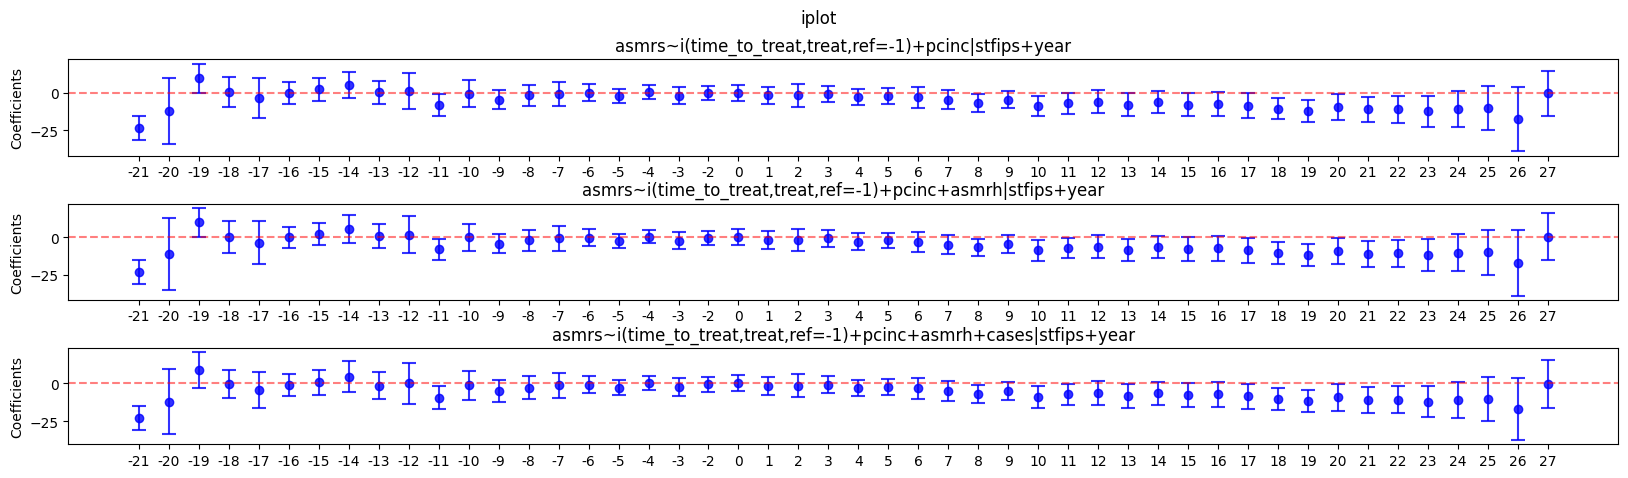

In [20]:
import pandas as pd
import numpy as np

# Read in data
df = pd.read_csv(
    "https://raw.githubusercontent.com/LOST-STATS/LOST-STATS.github.io/master/Model_Estimation/Data/Event_Study_DiD/bacon_example.csv"
)

df["time_to_treat"] = (df["year"] - df["_nfd"]).fillna(0).astype(int)
df["time_to_treat"] = pd.Categorical(
    df.time_to_treat, np.sort(df.time_to_treat.unique())
)
df["treat"] = np.where(pd.isna(df["_nfd"]), 0, 1)

fml = "asmrs ~ i(time_to_treat, treat, ref = -1) + csw(pcinc, asmrh, cases) | stfips + year"
fit = feols(fml=fml, data=df, vcov={"CRV1": "stfips"})
fit.iplot(yintercept=0, figsize=(20, 5))